# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [1]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [2]:
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

# Part 1: Preprocessing

## Train Dataset
**Note**: Will use encoder in pipeline in Part 2

In [3]:
train1 = train.iloc[:,:-1].copy()
y_train = train.iloc[:,-1].copy()
test1 = test.iloc[:,:-1].copy()
y_test = test.iloc[-1].copy()

In [4]:
train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type', 'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date', 'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location', 'Fail'], dtype='object')

In [206]:
test.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type', 'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date', 'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location', 'Fail'], dtype='object')

### Dropping Columns

In [5]:
train1 = train1.drop(columns=['Inspection ID', 'License #', 'Address', 'AKA Name',
                              'State', 'Zip', 'Location', 'Latitude', 'Longitude'])

### New `Major Chain` Feature

In [6]:
major_chains = (train['DBA Name'].value_counts() > 20).head(88)

In [7]:
train1['Major Chain'] = train['DBA Name'].isin(major_chains)

### Editing `Risk` Feature

In [8]:
train1.Risk.unique()

array(['Risk 1 (High)', 'Risk 3 (Low)', 'Risk 2 (Medium)', nan],
      dtype=object)

In [9]:
train1['High Risk'] = train1['Risk'].str.contains('1', na=False)
train1['Medium Risk'] = train1['Risk'].str.contains('2', na=False)
train1['Low Risk'] = train1['Risk'].str.contains('3', na=False)

In [10]:
train1 = train1.drop(columns=['DBA Name', 'Risk'])

### Editing `City`

In [11]:
chicago_fix = {'CCHICAGO': 'CHICAGO', 'CHCHICAGO': 'CHICAGO',
               'CHICAGOI': 'CHICAGO', 'CHICAGOCHICAGO': 'CHICAGO',
               'CHICAGOHICAGO': 'CHICAGO'}
train1['City'] = train1['City'].str.upper()
train1['City'] = train['City'].map(chicago_fix)

In [12]:
train1['In City'] = train1['City'] == 'CHICAGO'
train1['Suburb'] = train1['City'] != 'CHICAGO'

In [13]:
train1 = train1.drop(columns=['City'])

### `Facility Type`

- Form groups in 'Facility Type': 
'daycare|schools|shcool/hospital|nursing|shelter'
'restaurant|bakery|desserts|gelato|candy|paleteria|diner|catering|cafeteria|mobile'
'grocery|store|kiosk|wholesale|gas|tent|pantry'
'butcher|poultry|farm'

In [14]:
train1['Facility Type'] = train1['Facility Type'].str.lower()

train1['School/Health Facility'] = train1['Facility Type'].str.contains(
    'daycare|schools|school|shcool|hospital|nursing|shelter|care', regex=True, na=False)

train1['Restaurant/Dessert Service'] = train1['Facility Type'].str.contains(
    'restaurant|bakery|desserts|dessert|gelato|candy|paleteria|diner|catering|cafeteria|mobile|salad',
    regex=True, na=False)

train1['Food Store Facility'] = train1['Facility Type'].str.contains(
    'grocery|store|kiosk|wholesale|gas|tent|pantry|drug', regex=True, na=False)

train1['Animal Processing Facility'] = train1['Facility Type'].str.contains(
    'butcher|poultry|farm', regex=True, na=False)

In [15]:
train1 = train1.drop(columns=['Facility Type'])

### `Inspection Date`

In [16]:
# Transform earliest_cr_line to an integer: how many days it's been open
train1['Inspection Date'] = pd.to_datetime(train1['Inspection Date'], infer_datetime_format=True) # `infer_datetime_format=True` makes it go faster
train1['Inspection Month'] = train1['Inspection Date'].dt.month # .dt accessor is very useful to get 'days' or 'months'... 
# if you get the 'months' (which are from 1 to 12) you can categorically or ordinally encode that

In [17]:
train1 = train1.drop(columns=['Inspection Date'])

### Editing `Violations`

In [18]:
train1['Violations'] = train1['Violations'].str.lower()

train1['Serious Violations'] = train1['Violations'].str.contains('serious')
train1['Serious Violations'] = train1['Serious Violations'].fillna(
                                train1['Serious Violations'].mode())

In [19]:
train1 = train1.drop(columns=['Violations'])

In [20]:
train1['Inspection Type'] = train1['Inspection Type'].str.replace('nan', 'Canvass')

In [21]:
train1.head()

,Inspection Type,Major Chain,High Risk,Medium Risk,Low Risk,In City,Suburb,School/Health Facility,Restaurant/Dessert Service,Food Store Facility,Animal Processing Facility,Inspection Month,Serious Violations
0,Canvass,False,True,False,False,False,True,False,True,False,False,9,True
1,Complaint Re-Inspection,False,False,False,True,False,True,False,False,True,False,10,False
2,Canvass Re-Inspection,False,True,False,False,False,True,False,True,False,False,4,False
3,Canvass,False,False,True,False,False,True,False,True,False,False,4,False
4,Canvass,False,True,False,False,False,True,True,False,False,False,1,False


In [41]:
X_train = train1.copy()

## Test Dataset
**Note**: Will use encoder in pipeline in Part 2

### Dropping Columns

In [22]:
test1 = test1.drop(columns=['Inspection ID', 'License #', 'Address', 'AKA Name',
                              'State', 'Zip', 'Location', 'Latitude', 'Longitude'])

In [23]:
test1.columns

Index(['DBA Name', 'Facility Type', 'Risk', 'City', 'Inspection Date', 'Inspection Type', 'Violations'], dtype='object')

### New `Major Chain` Feature

In [24]:
major_chains = (test['DBA Name'].value_counts() > 20).head(88)

In [25]:
test1['Major Chain'] = test['DBA Name'].isin(major_chains)

### Editing `Risk` Feature

In [26]:
test1['High Risk'] = test1['Risk'].str.contains('1', na=False)
test1['Medium Risk'] = test1['Risk'].str.contains('2', na=False)
test1['Low Risk'] = test1['Risk'].str.contains('3', na=False)

In [27]:
test1 = test1.drop(columns=['DBA Name', 'Risk'])

### Editing `City`

In [28]:
chicago_fix = {'CCHICAGO': 'CHICAGO', 'CHCHICAGO': 'CHICAGO',
               'CHICAGOI': 'CHICAGO', 'CHICAGOCHICAGO': 'CHICAGO',
               'CHICAGOHICAGO': 'CHICAGO'}
test1['City'] = test1['City'].str.upper()
test1['City'] = test1['City'].map(chicago_fix)

In [29]:
test1['In City'] = test1['City'] == 'CHICAGO'
test1['Suburb'] = test1['City'] != 'CHICAGO'

In [30]:
test1 = test1.drop(columns=['City'])

### `Facility Type`

- Form groups in 'Facility Type': 
'daycare|schools|shcool/hospital|nursing|shelter'
'restaurant|bakery|desserts|gelato|candy|paleteria|diner|catering|cafeteria|mobile'
'grocery|store|kiosk|wholesale|gas|tent|pantry'
'butcher|poultry|farm'

In [31]:
test1['Facility Type'] = test1['Facility Type'].str.lower()

test1['School/Health Facility'] = test1['Facility Type'].str.contains(
    'daycare|schools|school|shcool|hospital|nursing|shelter|care', regex=True, na=False)

test1['Restaurant/Dessert Service'] = test1['Facility Type'].str.contains(
    'restaurant|bakery|desserts|dessert|gelato|candy|paleteria|diner|catering|cafeteria|mobile|salad',
    regex=True, na=False)

test1['Food Store Facility'] = test1['Facility Type'].str.contains(
    'grocery|store|kiosk|wholesale|gas|tent|pantry|drug', regex=True, na=False)

test1['Animal Processing Facility'] = test1['Facility Type'].str.contains(
    'butcher|poultry|farm', regex=True, na=False)

In [32]:
test1 = test1.drop(columns=['Facility Type'])

### `Inspection Date`

In [33]:
# Transform earliest_cr_line to an integer: how many days it's been open
test1['Inspection Date'] = pd.to_datetime(test1['Inspection Date'], infer_datetime_format=True) # `infer_datetime_format=True` makes it go faster
test1['Inspection Month'] = test1['Inspection Date'].dt.month # .dt accessor is very useful to get 'days' or 'months'... 
# if you get the 'months' (which are from 1 to 12) you can categorically or ordinally encode that

In [34]:
test1 = test1.drop(columns=['Inspection Date'])

In [35]:
test1.columns

Index(['Inspection Type', 'Violations', 'Major Chain', 'High Risk', 'Medium Risk', 'Low Risk', 'In City', 'Suburb', 'School/Health Facility', 'Restaurant/Dessert Service', 'Food Store Facility', 'Animal Processing Facility', 'Inspection Month'], dtype='object')

In [36]:
test1.columns

Index(['Inspection Type', 'Violations', 'Major Chain', 'High Risk', 'Medium Risk', 'Low Risk', 'In City', 'Suburb', 'School/Health Facility', 'Restaurant/Dessert Service', 'Food Store Facility', 'Animal Processing Facility', 'Inspection Month'], dtype='object')

### Editing `Violations`

In [37]:
test1['Violations'] = test1['Violations'].str.lower()

test1['Serious Violations'] = test1['Violations'].str.contains('serious')
test1['Serious Violations'] = test1['Serious Violations'].fillna(
                                test1['Serious Violations'].mode())

In [38]:
test1 = test1.drop(columns=['Violations'])

In [39]:
test1['Inspection Type'] = test1['Inspection Type'].str.replace('nan', 'Canvass')

In [40]:
test1.head()

,Inspection Type,Major Chain,High Risk,Medium Risk,Low Risk,In City,Suburb,School/Health Facility,Restaurant/Dessert Service,Food Store Facility,Animal Processing Facility,Inspection Month,Serious Violations
0,Canvass,False,False,True,False,False,True,False,False,True,False,3,False
1,Canvass,False,True,False,False,False,True,False,True,False,False,9,False
2,Canvass,False,True,False,False,False,True,False,True,False,False,3,False
3,Canvass Re-Inspection,False,True,False,False,False,True,False,True,False,False,10,True
4,Canvass,False,False,True,False,False,True,True,False,False,False,4,True


In [42]:
X_test = test1.copy()

# Part 2

In [46]:
import category_encoders as ce
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

pipe = make_pipeline(
    ce.BinaryEncoder(), 
    GradientBoostingClassifier(learning_rate=0.1, 
                               n_estimators=100,
                               max_depth=3)
)

param_grid = {
    'gradientboostingclassifier__learning_rate': [0.05],
    'gradientboostingclassifier__n_estimators': [500],
    'gradientboostingclassifier__max_depth': [4]
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3,
                         scoring='roc_auc', verbose=10)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gradientboostingclassifier__learning_rate=0.05, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=500 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gradientboostingclassifier__learning_rate=0.05, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=500, score=0.9196085975466628, total=  17.7s
[CV] gradientboostingclassifier__learning_rate=0.05, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=500 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.3s remaining:    0.0s


[CV]  gradientboostingclassifier__learning_rate=0.05, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=500, score=0.9162386950974715, total=  18.3s
[CV] gradientboostingclassifier__learning_rate=0.05, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=500 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.2s remaining:    0.0s


[CV]  gradientboostingclassifier__learning_rate=0.05, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=500, score=0.9156427280683802, total=  18.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('binaryencoder', BinaryEncoder(cols=None, drop_invariant=False, handle_unknown='impute',
       impute_missing=True, return_df=True, verbose=0)), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', m...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gradientboostingclassifier__learning_rate': [0.05], 'gradientboostingclassifier__n_estimators': [500], 'gradientboostingclassifier__max_depth': [4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [47]:
# Best score using 'ROC_AUC'
print('CV Score:', grid.best_score_)

CV Score: 0.9171633873377689


# Part 3

## Partial Dependence Plot

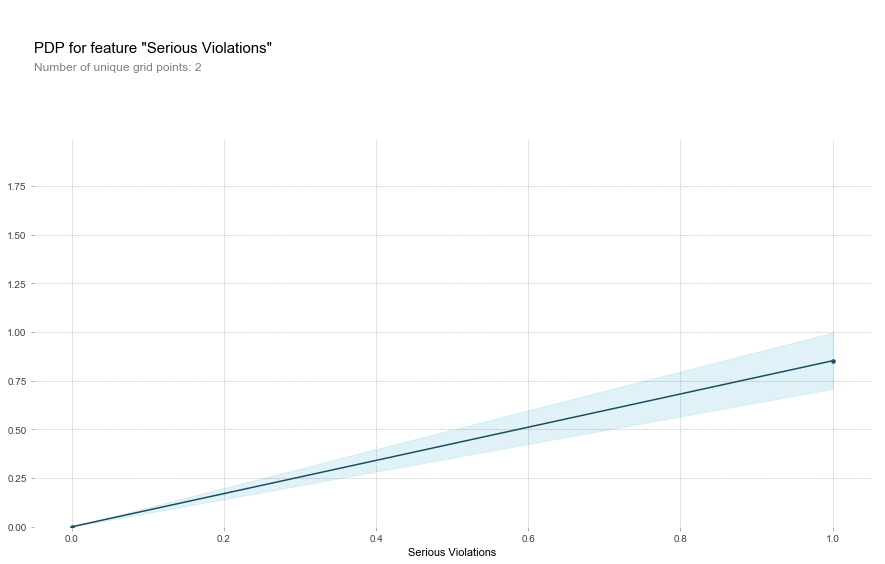

In [54]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='Serious Violations'
pdp_isolated = pdp_isolate(model=grid, dataset=X_train, model_features=X_train.columns, 
                           feature=feature)

pdp_plot(pdp_isolated, feature);